# 5 Elasticities
Shock elasticites are computed by solving:

$$
\varepsilon_M(t,x) = \nu(x) \cdot \left\{ \sigma_M(x) + \sigma_X(x) \cdot \frac{\partial}{\partial x} \log \mathbb{E}\left[ \left( \frac{M_t}{M_0} \right) \mid X_0 = x \right] \right\}
$$

Shock price-elasticities can be computed using:
$$
\varepsilon_M(t,x) - \varepsilon_{SM}(t,x)
$$

Where $S$ is the stochastic discount factor.

This can either be solved using finite differences or simulated. We describe both methods here.



# 5.1 Finite Differences
We compute elasticities using the finite differences method described in Supplemental Appendix C.3. Where ${\hat{M}}=\log{M}$:

$$
0 = - \frac{\partial f_{\hat{M}}}{\partial t} + \Big( \mu_{\hat{M}} + \frac{1}{2} \| \sigma_{\hat{M}} \|^2 \Big) f_{\hat{M}} + \big( \mu_X + \sigma_{\hat{M}} \cdot \sigma_X \big) \cdot \frac{\partial f_{\hat{M}}}{\partial x} + \frac{1}{2} \text{tr}\Big( \sigma_X \sigma_X' \frac{\partial^2 f_{\hat{M}}}{\partial x \partial x'} \Big)
$$

The finite differences elasticities code is implemented for all model environments in the paper, but we will focus on the baseline model in this section.  The main function for calculating elasticities is `main_pde_shock_elasticity`, which takes in the same inputs as the solution script, which in this case is `main_onecapital`. These inputs are used to identify a saved solution; therefore, this function must be run after the solution script has finished running.

There are several parameters which can be changed inside the body of `main_pde_shock_elasticity`. Notably, `dt` controls the time step, where `dt`=1 is one year, while `T` controls the total number of `dt` periods for which the elasticity is computed.

Within `main_pde_shock_elasticity`, the function `compute_pde_shock_elasticity` computes shock-exposure and shock-price elasticities for a given cash flow variable $M$ and stochastic discount factor $S$. These variables are specified by inputting their drift - `mulogM` and `mulogS` - and diffusion terms - `sigmalogM` and `sigmalogS`. For the baseline model, by default, the code computes drifts and diffusions for the following $M$ variables:

```{list-table}
:header-rows: 1

* - $\hat{M}$
  - Notation in paper
  - Description
* - `logcmk`
  - $\log{\frac{C}{K}}$
  - Log consumption-capital ratio
* - `logimo`
  - $\log{\frac{I}{Y}}$
  - Log investment-output ratio
* - `logc`
  - $\log{C}$
  - Log consumption
```

And the following $S$ variables:

```{list-table}
:header-rows: 1

* - $\hat{S}$
  - Notation in paper
  - Description
* - `logsdf`
  - $\hat{S}$
  - Log stochastic discount factor
* - `logn`
  - $\hat{N}$
  - Log uncertainty component of SDF
```

The user can also set the initial state. `marginal_quantile` is a dictionary which computes the quantiles of the marginal stationary distribution of each state. For example, `marginal_quantile['Z'](0.5)` computes the median of the marginal distribution of `Z`. Since the states consist of $Z^1$ (`Z` in the code) and $Z^2$ (`Y` in the code), we can define the initial state as follows:

In [ ]:
initial_points = [[marginal_quantile['Z'](0.5),marginal_quantile['Y'](0.1)],
                    [marginal_quantile['Z'](0.5),marginal_quantile['Y'](0.5),
                    marginal_quantile['Z'](0.5),marginal_quantile['Y'](0.9)]]

In the above example, we initialize $Z^2$ at its 10th, 50th and 90th percentiles while holding $Z^1$ at its median. 

First we import the necessary libraries:

In [1]:
import os
import sys
import numpy as np
from scipy.interpolate import RegularGridInterpolator as RGI
import argparse
import matplotlib.pyplot as plt

os.chdir("src/1/")
from main_pde_shock_elasticity import main
from utils_FDM import finiteDiff_2D_first, finiteDiff_2D_second, finiteDiff_2D_cross
from utils_pde_shock_elasticity import computeElas
from plot_function import return_solution, plot_solution
os.chdir("../../")

Next, we set the elasticity inputs. Remember that a solution must be saved under the same parameters before the elasticities can be computed.

In [2]:
alpha = 0.0922
delta = 0.01
gamma = 1.0
Delta = 1.0
rho = 1.0
action_name = "test"

After changing these settings to your liking, we can run `main_pde_shock_elasticity`. Using default settings, this takes 20 seconds.

In [13]:
main(Delta, delta, gamma, rho, alpha, action_name)

--- 12.889362812042236 seconds for the elasticity computation ---
--- 4.820237636566162 seconds for the elasticity computation ---
--- 3.97141170501709 seconds for the elasticity computation ---


Once the above function has finished running, we can load in the results. The elasticity for each $M$ is saved as a separate `npz` file, but we can load all of them at once using the `return_solution` function.

In [24]:
res = return_solution(rho, gamma, Delta, delta, alpha, action_name)
res

{'res': NpzFile './output/test/Delta_1.0/delta_0.01/gamma_1.0_rho_1.0_alpha_0.0922/res.npz' with keys: ymax, V, dy, a22, zz...,
 'elasticity_logc': NpzFile './output/test/Delta_1.0/delta_0.01/gamma_1.0_rho_1.0_alpha_0.0922/elasticity_logc.npz' with keys: exposure_elasticity, price_elasticity,
 'elasticity_logimo': NpzFile './output/test/Delta_1.0/delta_0.01/gamma_1.0_rho_1.0_alpha_0.0922/elasticity_logimo.npz' with keys: exposure_elasticity, price_elasticity,
 'uncertainty_priceelas': NpzFile './output/test/Delta_1.0/delta_0.01/gamma_1.0_rho_1.0_alpha_0.0922/uncertainty_priceelas.npz' with keys: exposure_elasticity, price_elasticity}

For example, we can load the first-type exposure elasticities for $\hat{C}$ by accessing `['elasticity_logc']['exposure_elasticity'].item().firstType`. The first index of this object is the initial state; 0 represents the first initialization, which in this case is $Z^1$ at median and $Z^2$ at 10th percentile. The second index is the shock index; in this case, 1 represents a growth-rate shock. The third index is time. To illustrate this, we have written a simple `plot_solution` function, but the user can edit this to display their desired results.

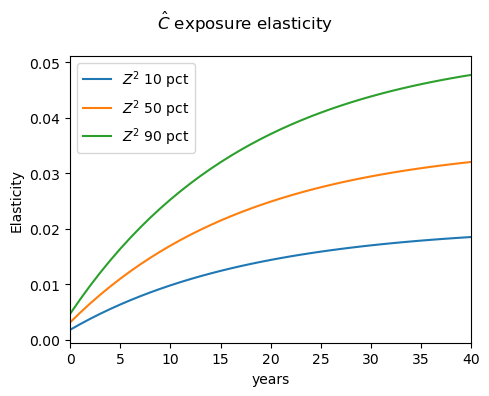

In [55]:
plot_solution(rho, gamma, Delta, delta, alpha, action_name)

# 5.2 Simulation

Alternatively, we can compute elasticities by simulation. Specifically, we use simulations to estimate:

$$
\frac{\partial}{\partial x} \log \mathbb{E}\Big[ \Big( \frac{M_t}{M_0} \Big) \mid X_0 = x \Big],\\
\frac{\partial}{\partial x} \log \mathbb{E}\Big[ \Big( \frac{S_tM_t}{S_0M_0} \Big) \mid X_0 = x \Big]
$$

Currently, this method is only implemented for the heterogeneous agents environment in Section 5, but the user can easily modify the code to adapt to the other environments. 

The solution scripts give us the objects we need: [`\mu_X`, `\sigma_X`, `\mulogM`, `\sigmalogM`, `\mulogS`, `\sigmalogS`] to perform simulations. These objects are interpolated on the state space grid using the `scipy.interpolate.RegularGridInterpolator` function. We initialize the states at $X_0$ and simulate `sim_num`*100 independent Brownian motion processes ${B_t}$ with length $T$, use these to evaluate ${X_t}$. Using the interpolations, we can compute ${M_t/M_0}$ and ${S_t/S_0}$ and thus estimate the expectation term.  We repeat this with initial state $X_0+dx$ and use this to estimate the derivative of the expectation.


Similar to the finite differences code, `main_sim_shock_elasticity` takes the same inputs as the main solution script, with the addition of [`W_percentile`,`Z_percentile`,`V_percentile`], which characterise the initial state $X_0$. We recommend using a remote computing resource to run this program, which may take around an hour per elasticity computed.

In addition, the `main_sim_shock_elasticity` script can be edited to change the following parameters:

```{list-table}
:header-rows: 1

* - Parameter
  - Description
  - Default Value
* - `sim_num`
  - Number of simulations is `sim_num`$*100$
  - 100
* - `sim_length`
  - Simulation length in years
  - 50
* - `shock_index`
  - Shock index: 0 for the capital shock, 1 for growth shock and 2 for volatility shock
  - 0
* - `dx`
  - Step-size for state derivative
  - `[0.01, 0.01, 1e-7]`
* - `dt`
  - Time step
  - 1
* - `statespace`
  - State space
  - `[W, Z, V]`
* - `muX`
  - State variable drift terms
  - `[muW, muZ, muV]`
* - `sigmaX`
  - State variable diffusion terms
  - `[sigmaW, sigmaZ, sigmaV]`
* - `mulogM`
  - Log drift term for the response variable M
  - `mulogW`
* - `sigmalogM`
  - Log diffusion terms for the response variable M
  - `sigmalogW`
* - `mulogS`
  - Log drift term for the SDF
  - `logsdfe_drift`
* - `sigmalogS`
  - Log diffusion terms for the SDF
  - `logsdfe_diffusion`
```

The script saves the `exposure_elasticity` and `price_elasticity`. There is a chance that the simulation fails as $X_t$ may move outside the state space grid. The total number of successful simulations for $X_0$ and $X_0+dx$ are recorded as `initial_success_count` and `derivative_success_count`, respectively. By default, intermediate variables, such as $X_t/X_0$, are not saved; this can be altered by setting `return_type`=0. We now demonstrate the code:

In [1]:
import numpy as np
np.set_printoptions(suppress=True, linewidth=200)
import os
from scipy import interpolate
os.chdir("src/4")
from main_sim_shock_elasticity import main
from plot import return_sim_elasticity
os.chdir("../..")
import warnings
warnings.filterwarnings("ignore")
import argparse
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid", font_scale=1.13, rc={"lines.linewidth": 3.5})
plt.rcParams['axes.formatter.useoffset'] = True

We provide example parameters which follow the default example in Chapter 4 of this notebook. For illustration, we initialize $W$ and $Z^1$ at their medians, and $Z^2$ at its 90th percentile.

In [2]:
chiUnderline = 1.0
gamma_e = 4.0
a_e = 0.0922
a_h = 0.0
gamma_h = 4.0
delta_e = 0.0115
delta_h = 0.01
lambda_d = 0.0
rho_e = 1.0
rho_h = 1.0
nu = 0.1
V_bar = 0.0000063030303030303026
sigma_K_norm = 3.1707442821755683
sigma_Z_norm = 19.835431735873996
sigma_V_norm = 0.0010882177801089308
wMin = 0.01
wMax = 0.99
nWealth = 180
nZ = 30
nV = 30
seed = 256
n_layers = 2
units = 16
points_size = 10
iter_num = 5
penalization = 10000
BFGS_maxiter = 100
BFGS_maxfun = 100
action_name = 'test'
shock_expo = 'upper_triangular'
W_percentile = 0.5
Z_percentile = 0.5
V_percentile = 0.9


Next, we run the simulation. This can take more than an hour using default settings.

In [ ]:
main(chiUnderline = 1.0, gamma_e = 4.0, a_e = 0.0922, a_h = 0.0, gamma_h = 4.0, delta_e = 0.0115, delta_h = 0.01, lambda_d = 0.0, rho_e = 1.0, rho_h = 1.0, nu = 0.1, V_bar = 0.0000063030303030303026, sigma_K_norm = 3.1707442821755683, sigma_Z_norm = 19.835431735873996, sigma_V_norm = 0.0010882177801089308, wMin = 0.01, wMax = 0.99, nWealth = 180, nZ = 30, nV = 30, seed = 256, n_layers = 2, units = 16, points_size = 10, iter_num = 5, penalization = 10000, BFGS_maxiter = 100, BFGS_maxfun = 100, action_name = 'test', shock_expo = 'upper_triangular', W_percentile = 0.5, Z_percentile = 0.5, V_percentile = 0.9)

We now load the results and plot an example.

In [3]:
sim = return_sim_elasticity(shock_expo = shock_expo, seed = seed, chiUnderline = chiUnderline, a_e = a_e, a_h = a_h, gamma_e = gamma_e, gamma_h = gamma_h, psi_e = rho_e, psi_h = rho_h, delta_e = delta_e, delta_h = delta_h, lambda_d = lambda_d, nu = nu, n_layers = n_layers, units = units, iter_num = iter_num, points_size = points_size, penalization = penalization, action_name = action_name, W_percentile = W_percentile, Z_percentile = Z_percentile, V_percentile = V_percentile)

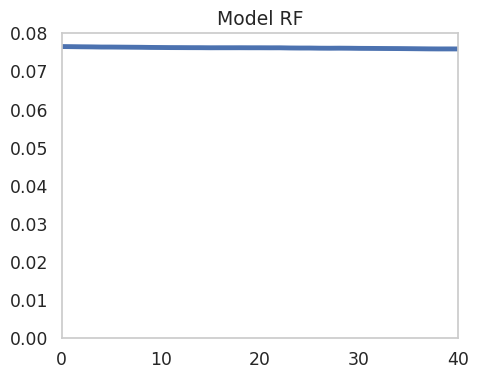

In [6]:
fig, axes = plt.subplots(1,1, figsize=(5,4))

sns.lineplot(sim['elasticity']['price_elasticity'], ax = axes)
axes.set_title(r'Model RF')
axes.set_xlim(0,40)
axes.grid(False)
# axes.set_ylim([0,0.08])

plt.subplots_adjust(wspace=0.3, hspace=0.25)
plt.tight_layout()